In [23]:
from sklearn import metrics
import pandas as pd
import numpy as np
import math
import random
import os
import time
import matplotlib.pyplot as plt
import sklearn

import matplotlib.gridspec as gridspec
import matplotlib


def build_y_true(row):
    tps = row['true_positives']
    pop = row['population']
    return np.array([1] * tps + [0] * (pop - tps))

def simulate_predictor(tpr, fpr, y_true, info=False):
    y_pred = []
    tpr_cuttoff = math.floor(tpr * len(list(filter(lambda x: x, y_true))))
    selected_tp = 0
    info and print(f"Going to select {tpr_cuttoff} ({tpr} of {len(y_true)}) true samples")
    fpr_cuttoff = math.floor(fpr * len(list(filter(lambda x: not x, y_true))))
    selected_fp = 0
    info and print(f"Going to select {fpr_cuttoff} ({fpr} of {len(y_true)}) false samples")
    for i, y in enumerate(y_true):
        if y == 1:
            if selected_tp < tpr_cuttoff:
                y_pred.append(1)
                selected_tp += 1
            else:
                y_pred.append(0)
        if y == 0:
            if selected_fp < fpr_cuttoff:
                selected_fp += 1
                y_pred.append(1)
            else:
                y_pred.append(0)
    return y_pred


def apply_predictor_for_grid(metric, y_true, s=20):
    grid = []
    tpr_range = np.linspace(1/s, 1, s)[:-1]
    fpr_range = np.linspace(1/s, 1, s)[:-1]
    for tpr in tpr_range:
        row = []
        for fpr in fpr_range:
            y_pred = simulate_predictor(tpr, fpr, y_true)
            row.append(metric(y_pred, y_true))
        grid.append(np.array(row))
    return tpr_range, fpr_range, np.array(grid)

metrics_to_track = [
        ('precision', lambda y_pred, y_true: metrics.precision_score(y_true, y_pred, zero_division=0)),
        ('weighted precision', lambda y_pred, y_true: metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0)),
        ('average_precision', lambda y_pred, y_true: metrics.average_precision_score(y_true, y_pred)),
        ('recall', lambda y_pred, y_true: metrics.recall_score(y_true, y_pred, zero_division=0)),
        ('weighted recall', lambda y_pred, y_true: metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0)),
        ('f1 score', lambda y_pred, y_true: metrics.f1_score(y_true, y_pred)),
        ('weighted f1 score', lambda y_pred, y_true: metrics.f1_score(y_true, y_pred, average='weighted')),
        ('accuracy', lambda y_pred, y_true: metrics.accuracy_score(y_true, y_pred)),
]

In [2]:
def get_population(true_positives, popsize):
    population = [1] * true_positives + [0] * (popsize - true_positives)
    random.shuffle(population)
    return population


In [29]:
y_true = get_population(6, 12)
#y_pred = simulate_predictor(2/3, 1/6, y_true)
y_pred = simulate_predictor(1/2, 1/2, y_true)

metrics.precision_score(y_true, y_pred)


0.5

In [30]:
y_true

[0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]

In [31]:
y_pred

[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]

In [24]:
ground_truth = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
classifier_output = [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
sklearn.metrics.precision_score(ground_truth, classifier_output)

0.8

Processing precision @ psize=104 (T=77.0%/F=23.0%)
Processing weighted precision @ psize=104 (T=77.0%/F=23.0%)
Processing average_precision @ psize=104 (T=77.0%/F=23.0%)
Processing recall @ psize=104 (T=77.0%/F=23.0%)
Processing weighted recall @ psize=104 (T=77.0%/F=23.0%)
Processing f1 score @ psize=104 (T=77.0%/F=23.0%)
Processing weighted f1 score @ psize=104 (T=77.0%/F=23.0%)
Processing accuracy @ psize=104 (T=77.0%/F=23.0%)
Processing precision @ psize=160 (T=50.0%/F=50.0%)
Processing weighted precision @ psize=160 (T=50.0%/F=50.0%)
Processing average_precision @ psize=160 (T=50.0%/F=50.0%)
Processing recall @ psize=160 (T=50.0%/F=50.0%)
Processing weighted recall @ psize=160 (T=50.0%/F=50.0%)
Processing f1 score @ psize=160 (T=50.0%/F=50.0%)
Processing weighted f1 score @ psize=160 (T=50.0%/F=50.0%)
Processing accuracy @ psize=160 (T=50.0%/F=50.0%)
Processing precision @ psize=240 (T=33.0%/F=67.0%)
Processing weighted precision @ psize=240 (T=33.0%/F=67.0%)
Processing average_pr

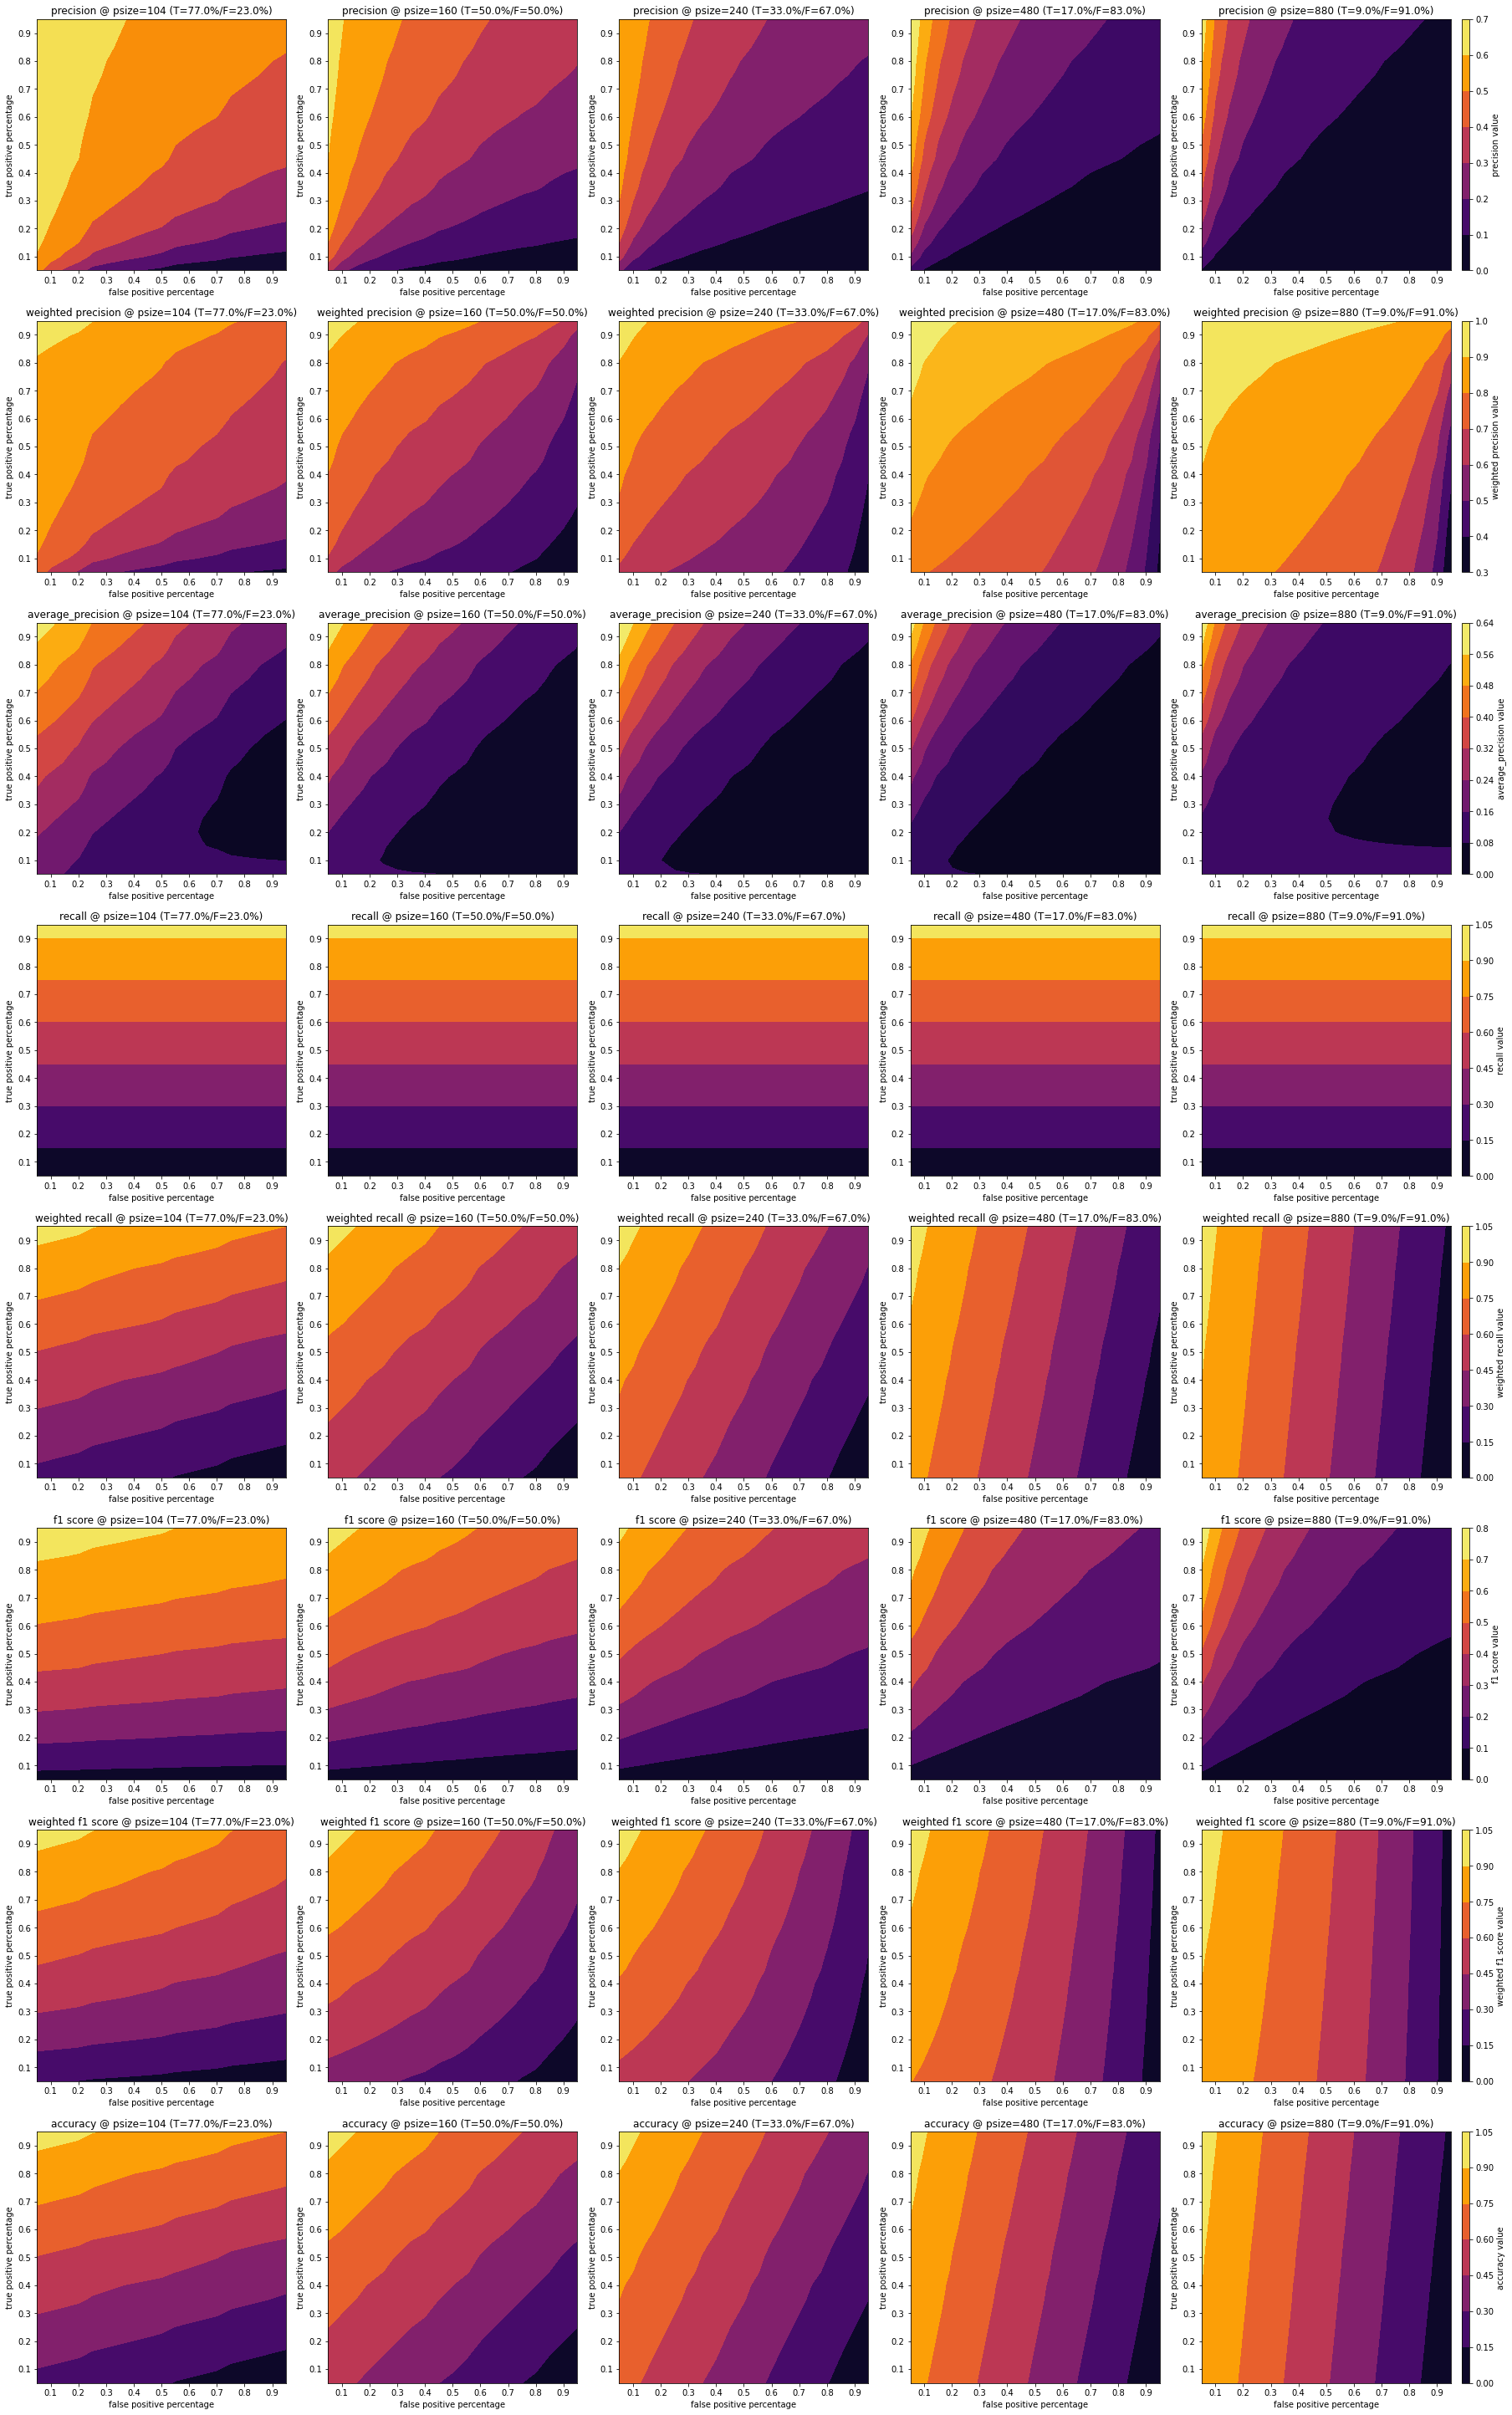

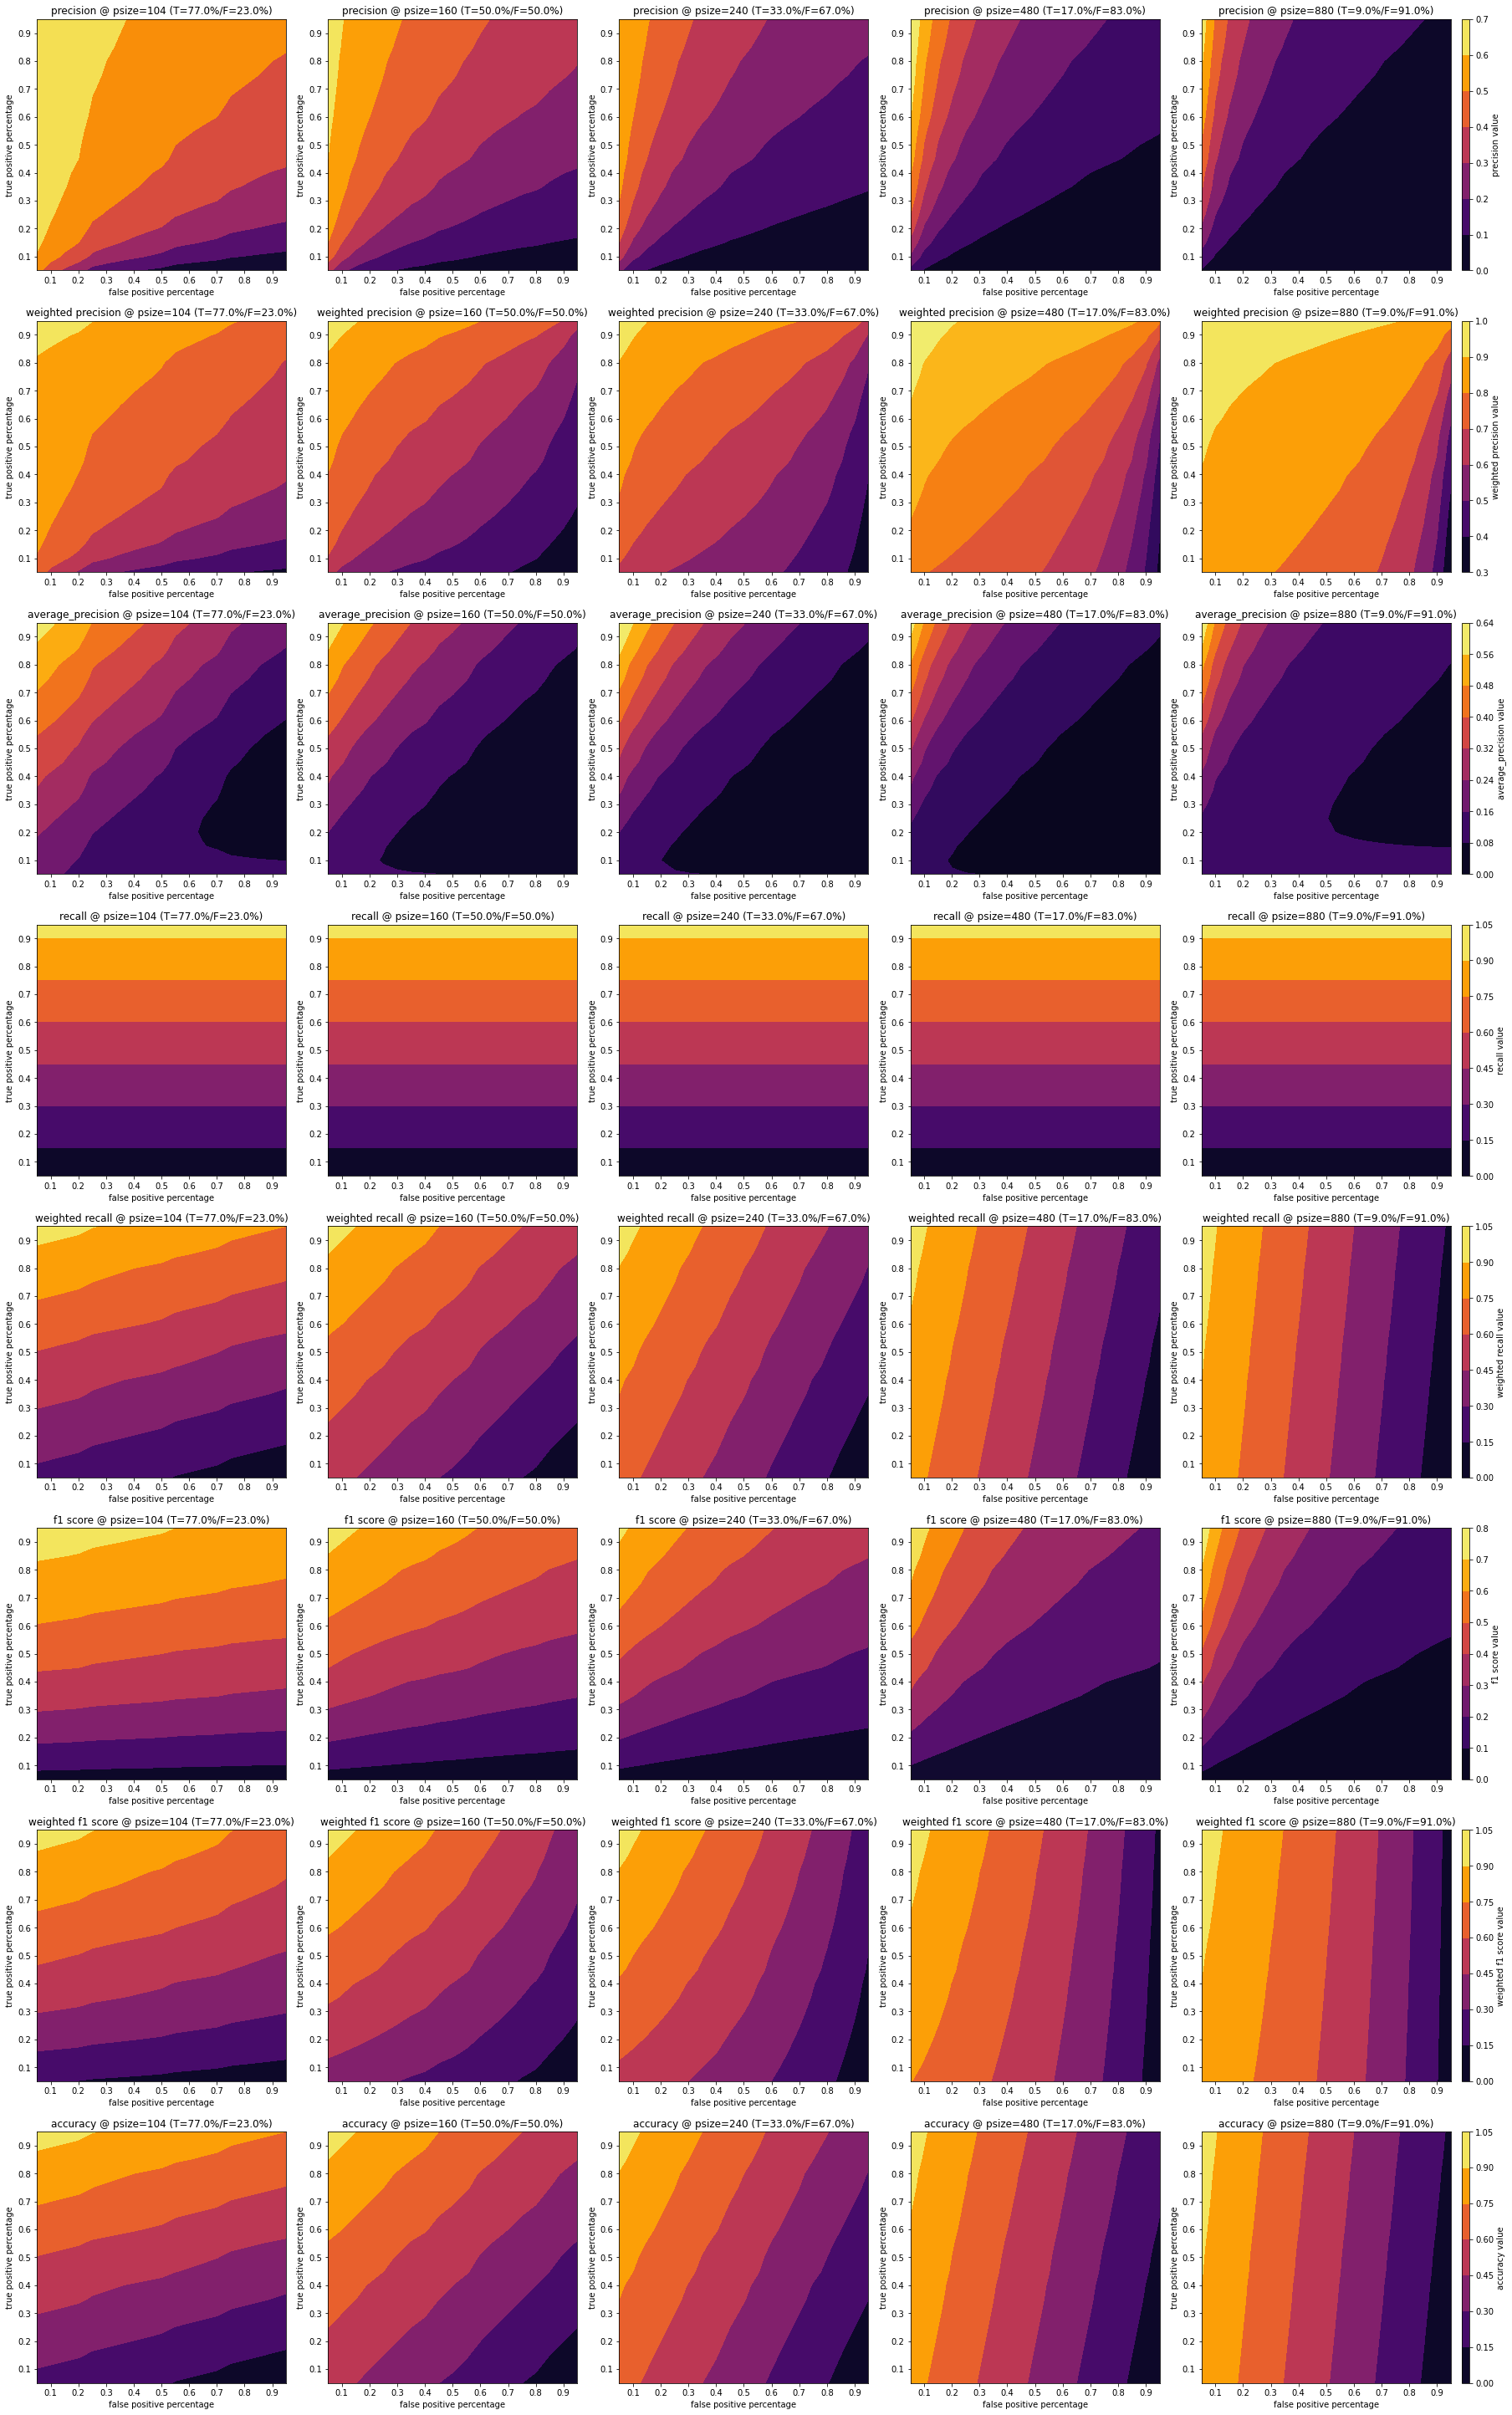

In [47]:
def plot_metric_chart(fig, ax, metric_name, metric, title, population_size, true_positives, plot_colorbar=False):
    print(f"Processing {title}")
    tpr_range, fpr_range, metric_values = apply_predictor_for_grid(
            metric,
            get_population(true_positives, population_size)
    )
    C = ax.contourf(tpr_range, fpr_range, metric_values, cmap=plt.cm.inferno)
    ax.set_ylabel('true positive percentage')
    ax.set_xlabel('false positive percentage')
    ax.set_title(f"{title}")
    if plot_colorbar:
        cbar = fig.colorbar(C)
        cbar.ax.set_ylabel(f'{metric_name} value')

true_positives = 80
population_sizes = [
    (true_positives, int(true_positives*0.3)),
    (true_positives, true_positives),
    (true_positives, 2*true_positives),
    (true_positives, 5*true_positives),
    (true_positives, 10*true_positives),
]
fig = plt.figure(constrained_layout=True, figsize=(5*len(poplation_sizes), 5*len(metrics_to_track)))
spec = gridspec.GridSpec(nrows=len(metrics_to_track), ncols=len(poplation_sizes), figure=fig)
for i, population_size in enumerate([sum(el) for el in population_sizes]):
    for j, (metric_name, metric) in enumerate(metrics_to_track):
        ax = fig.add_subplot(spec[j, i])
        plot_metric_chart(
            fig,
            ax,
            metric_name,
            metric,
            f"{metric_name} @ psize={population_size} (T={100*round(true_positives/population_size,2)}%/F={100 - 100*round(true_positives/population_size,2)}%)",
            population_size,
            true_positives,
            plot_colorbar=(i == len(population_sizes) - 1)
        )

filename=f'2d-all-metrics.png'
fig.set_rasterized(True)
fig.savefig(filename, dpi=96, facecolor='w', edgecolor='w', transparent=False)
fig

Processing precision @ psize=10 (T=50.0%/F=50.0%)


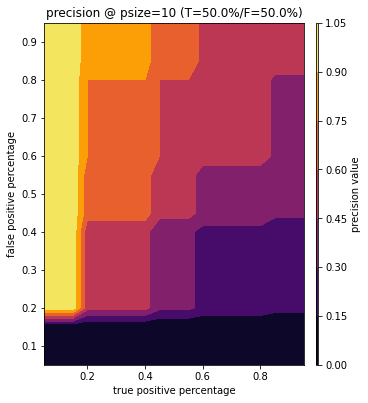

In [4]:
def plot_metric_chart(fig, ax, metric_name, metric, title, population_size, true_positives, plot_colorbar=False):
    print(f"Processing {title}")
    tpr_range, fpr_range, metric_values = apply_predictor_for_grid(
            metric,
            get_population(true_positives, population_size)
    )
    C = ax.contourf(tpr_range, fpr_range, metric_values, cmap=plt.cm.inferno)
    ax.set_xlabel('true positive percentage')
    ax.set_ylabel('false positive percentage')
    ax.set_title(f"{title}")
    if plot_colorbar:
        cbar = fig.colorbar(C)
        cbar.ax.set_ylabel(f'{metric_name} value')
    
poplation_sizes = [10]
#poplation_sizes = [100, 160]

true_positives = 5
fig = plt.figure(constrained_layout=True, figsize=(5*len(poplation_sizes), 5*len(metrics_to_track)))
spec = gridspec.GridSpec(nrows=len(metrics_to_track), ncols=len(poplation_sizes), figure=fig)
for i, population_size in enumerate(poplation_sizes):
    for j, (metric_name, metric) in enumerate(metrics_to_track[:1]):
        ax = fig.add_subplot(spec[j, i])
        plot_metric_chart(
            fig,
            ax,
            metric_name,
            metric,
            f"{metric_name} @ psize={population_size} (T={100*round(true_positives/population_size,2)}%/F={100 - 100*round(true_positives/population_size,2)}%)",
            population_size,
            true_positives,
            plot_colorbar=(i == 0)
        )

filename=f'demo-2d-all-metrics.png'
fig.set_rasterized(True)
fig.savefig(filename, dpi=96, facecolor='w', edgecolor='w', transparent=False)


In [42]:
psizes = np.array(population_sizes)
pd.DataFrame({
    '# of "1" values': psizes[:, 0],
    '# of "0" values': psizes[:, 1],
    'total population size': [sum(el) for el in psizes]

})

,"# of ""1"" values","# of ""0"" values",total population size
0,80,16,96
1,80,160,240
2,80,240,320
3,80,400,480
4,80,800,880
